In [2]:
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import matplotlib.pyplot as plt
from matplotlib import pyplot
from math import sqrt
from numpy import split
from numpy import array
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sympy.solvers import solve
from sympy import Symbol

In [3]:
# Importing dataframe
Global = pd.read_csv("C:/Users/airos/Documents/GitHub/FinalProjectEntity/Data/pivotedGlobal.csv")

Global.head()

,Unnamed: 0,Year,"Almonds, Shelled Basis","Apples, Fresh",Barley,"Coffee, Green",Corn,"Dairy, Milk, Fluid","Grapefruit, Fresh","Meat, Swine",Oats,"Oil, Soybean","Oilseed, Rapeseed",Rye,"Walnuts, Inshell Basis"
0,0,1998,235884.0,5282724.0,235884000.0,1.415304e+07,4.822010e+09,326151000.0,185000.0,4.740312e+12,247882000.0,4.176508e+09,5214000.0,2114000.0,205931.0
1,1,1999,377800.0,5746060.0,361362000.0,2.168172e+07,4.800686e+09,77534000.0,183000.0,4.476775e+12,239549000.0,3.797778e+09,662250000.0,2165000.0,256734.0
2,2,2000,318900.0,5675890.0,303700000.0,1.822200e+07,4.274204e+09,332092000.0,163000.0,2.395490e+11,251854000.0,3.946939e+09,307386000.0,1707000.0,216816.0
3,3,2001,376500.0,5065060.0,376488000.0,2.258928e+07,3.866379e+09,305319000.0,163000.0,2.518540e+11,241377000.0,4.354875e+09,312180000.0,1684000.0,276700.0
4,4,2002,494416.0,4605810.0,494416000.0,2.686065e+11,3.988483e+09,83581000.0,186000.0,3.871860e+11,227767000.0,4.433333e+09,332092000.0,2096000.0,255825.0


In [5]:
# Isolating 'Dairy, Milk, Fluid' first for ARIMA THEN 'Meat, Swine'
Swine = Global[['Meat, Swine', 'Year']]
Swine.head()

,"Meat, Swine",Year
0,4.740312e+12,1998
1,4.476775e+12,1999
2,2.395490e+11,2000
3,2.518540e+11,2001
4,3.871860e+11,2002


In [6]:
# Formatting Year to date datatype 
Swine['Year'] = pd.to_datetime(Swine['Year'], format='%Y')

C:\Users\airos\AppData\Local\Temp/ipykernel_6652/3598456331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Swine['Year'] = pd.to_datetime(Swine['Year'], format='%Y')


In [7]:
## Setting Year as index
Swine.set_index('Year', inplace=True)
type(Swine)

pandas.core.frame.DataFrame

<AxesSubplot:xlabel='Year'>

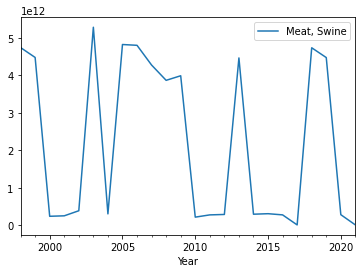

In [8]:
## Looking at linear plot of d,m,f, production
Swine.plot()

### Plot does look stationary, there is an obvious stationary portion to the plot with large spikes every three years.

In [11]:
## Testing our finding against Augmented Dickey Fuller test
result=adfuller(Swine['Meat, Swine'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.5058424843763576
n_lags: 0.1140592492365079
p-value: 0.1140592492365079
Critial Values:
   1%, -4.01203360058309
Critial Values:
   5%, -3.1041838775510207
Critial Values:
   10%, -2.6909873469387753


## P value is providing non-significant finding. We are going to reject the null hypothesis.
## The ADF Statistic is lower than all our critical value cuttoffs, indicating that Swine production may have a time 
## dependent structure since it does not have a constant variance over time.

In [13]:
Swine

,"Meat, Swine"
Year,
1998-01-01,4.740312e+12
1999-01-01,4.476775e+12
2000-01-01,2.395490e+11
2001-01-01,2.518540e+11
2002-01-01,3.871860e+11
2003-01-01,5.282724e+12
2004-01-01,3.037000e+11
2005-01-01,4.822010e+12
2006-01-01,4.800686e+12


In [14]:
# Splitting the data for training and testing
train = Swine[:20]
test =  Swine[-4:]
train
test

,"Meat, Swine"
Year,
2018-01-01,4.734966e+12
2019-01-01,4.473878e+12
2020-01-01,2.822600e+11
2021-01-01,9.147000e+09


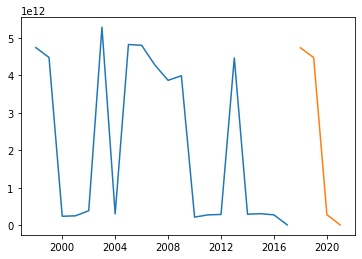

In [15]:
plt.plot(train)
plt.plot(test)

In [16]:
## Running auto_arima to obtain p, d, q variables
model = pm.auto_arima(Swine['Meat, Swine'], seasonal=False)
model

ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

# ARIMA(order=(p=0, d=0, q=0)

In [17]:
# Manually Building Auto ARIMA model
arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=0, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1196.451, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1199.385, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1199.045, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1208.663, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1197.853, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1197.338, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1199.210, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1197.700, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1198.024, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1199.598, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.422 seconds


# Best model confirmed p=0 d=0 q=0.
# model result  - ARIMA(0,0,0)(0,0,0)[12] intercept: AIC=1196.451

In [19]:
#Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                        SARIMAX   Log Likelihood                -596.226
Date:                Tue, 19 Jul 2022   AIC                           1196.451
Time:                        23:59:54   BIC                           1198.442
Sample:                             0   HQIC                          1196.840
                                 - 20                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.178e+12   4.79e+11      4.550      0.000    1.24e+12    3.12e+12
sigma2      4.584e+24      0.028   1.64e+26      0.000    4.58e+24    4.58e+24
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):                 3.11
Prob(Q):                              0.35   Prob(JB):                         0.21
Heteroskedasticity (H):               0.78   Skew:                             0.25
Prob(H) (two-sided):                  0.75   Kurtosis:                         1.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [20]:
# Forecasting on the test data
prediction = pd.DataFrame(arima_model.predict(n_periods = 4),index=test.index)
prediction.columns = ['predicted_values']
prediction

,predicted_values
Year,
2018-01-01,2.178437e+12
2019-01-01,2.178437e+12
2020-01-01,2.178437e+12
2021-01-01,2.178437e+12


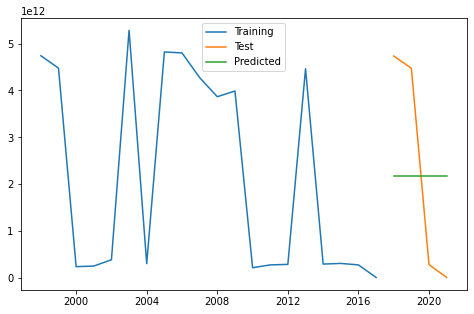

In [21]:
# Plotting against actual values
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
plt.show()

In [24]:
# Looking at R2 score
test['predicted_values'] = prediction
r2_score(test['Meat, Swine'], test['predicted_values'])

C:\Users\airos\AppData\Local\Temp/ipykernel_6652/940659276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_values'] = prediction


-0.007751082217843264

### INDICATES less error than Dairy ARIMA but still something to correct.

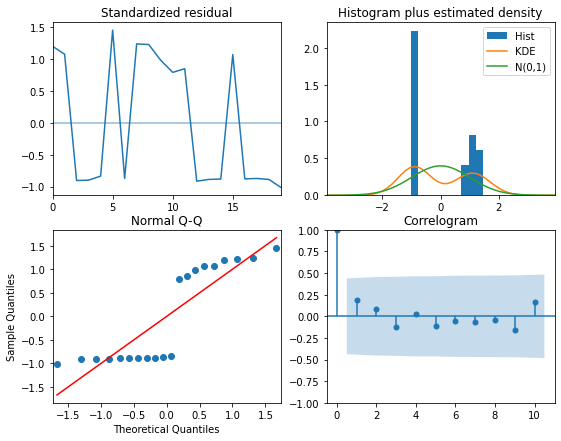

In [25]:
# Interpreting residual plots
arima_model.plot_diagnostics(figsize=(9,7))
plt.show()

### Upper left plot reveals pretty close variance on both sides of 0, Upper right plot reveals almost no normality 
### (I'd like to correct for this), Lower left reveals a high deviation of the points from the trend line (I'd like to correct for this),
### and the lower right reveals hardly any deviation from the projected range we are looking at. 

In [26]:
# Creating new dataframe for future forecasting
future = {'Year':  [2022, 2023, 2024, 2025],
        'predicted_values': ['NaN', 'NaN', 'NaN', 'NaN']}

future = pd.DataFrame(future)
print (future)

   Year predicted_values
0  2022              NaN
1  2023              NaN
2  2024              NaN
3  2025              NaN


In [27]:
# Formatting Year to date datatype 
future['Year'] = pd.to_datetime(future['Year'], format='%Y')

In [28]:
## Setting Year as index
future.set_index('Year', inplace=True)
type(future)
future

,predicted_values
Year,
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN
2025-01-01,NaN


In [30]:
# Appending Future DF to justSwine DF
futureprediction = Swine.append(future)
futureprediction

C:\Users\airos\AppData\Local\Temp/ipykernel_6652/1984544370.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  futureprediction = Swine.append(future)


,"Meat, Swine",predicted_values
Year,,
1998-01-01,4.740312e+12,NaN
1999-01-01,4.476775e+12,NaN
2000-01-01,2.395490e+11,NaN
2001-01-01,2.518540e+11,NaN
2002-01-01,3.871860e+11,NaN
2003-01-01,5.282724e+12,NaN
2004-01-01,3.037000e+11,NaN
2005-01-01,4.822010e+12,NaN
2006-01-01,4.800686e+12,NaN


In [31]:
# Setting number of points to forecast
h=28
# Generating forecast
forecast2 = pd.DataFrame(arima_model.predict(h), index=futureprediction.index)
forecast2.columns = ['predicted_values']
forecast2

,predicted_values
Year,
1998-01-01,2.178437e+12
1999-01-01,2.178437e+12
2000-01-01,2.178437e+12
2001-01-01,2.178437e+12
2002-01-01,2.178437e+12
2003-01-01,2.178437e+12
2004-01-01,2.178437e+12
2005-01-01,2.178437e+12
2006-01-01,2.178437e+12


In [ ]:
# 2023 Honey Prediction Values based off of Swine Commodity Forecasting


# ******Using Swine+Honey linear regression equation performed in Cat1Pivot; (Seq) = -55.5376(Honey)+13930000.0) we can solve for Honey.

### US Swine production for 2023 is forecasted at 2.178437e+12, or 2178437000000.0 Metric Tons.


### if we plug our values into the Linear regression formula Honey Production = 
### 2178437000000.0 = -55.5376(Honey)+13930000.0 (solving below)
### So Honey production is predicted to produce -39224292551.3526 metric tons in 2023.

In [32]:
2178437000000.0 - 13930000.0

2178423070000.0

In [33]:
2178423070000.0 /-55.5376

-39224292551.3526

### Honey = -39,224,292,551.3526